In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Us d'un nou optimitzador.
3. Visualització dels resultats dels filtres convolucionals.

In [6]:
# El label del dataset és l'índex de la llista labels. Cada posició de la llista és un codi ASCII. Podeu emprar la funció chr per fer la transformació

# Definim una seqüència (composició) de transformacions
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mitjana, desviacio tipica (precalculats)
    ])

# Descarregam un dataset ja integrat en la llibreria Pytorch:
train = datasets.EMNIST('data', split="digits", train=True, download=True, transform=transform)  ## Si acabau podeu fer proves amb el split "balanced"
test = datasets.EMNIST('data', split="digits",train=False, transform=transform)

In [7]:
classes =  test.classes

In [8]:
train_batch_size = 64
test_batch_size = 100

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)

## Definició de la xarxa

### Feina a fer

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:


- `Conv2d`: Capa convolucional en 2 dimensions. Com a paràmetres principals trobarem:

  - in_channels: canals d'entrada.
  - out_channels : canals de sortida (nombre de filtres).
  - kernel_size: mida del filtre.
  - stride: desplaçament del filtre. Típicament pren per valor 1.
  - padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

- `MaxPool2d`: Capa de max pooling. Aquesta capa no té paràmetres entrenables. Però si:

  - kernel_size: Mida del filtre del qual es seleccionarà el màxim.
  - stride: desplaçament del filtre.

- `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.


- `Linear`

- `ReLU`


2. Per posibilitar la visualització de les imatges passades per les capes convolucionals farem que funció `forward` tengui diverses sortides (diferents valors de `return`) un per cada capa convolucional de la xarxa.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(7*7*16, 32)
        self.linear_2 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.conv_1(x)
        x = self.max_pool2d(y)
        z = self.conv_2(x)
        x = self.max_pool2d(z)
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear_2(x)

        output = F.log_softmax(x, dim=1)
        return output, y, z

## Entrenament

Això no varia massa de la setmana anterior

### Feina a fer

1. Modificar la sortida de la xarxa, ara retorna diversos valors, encara que aquí només us interessa un.

In [10]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data)
         ## Aquesta setmana empram la cross_entropy com una funció a diferència de la stmana passada
        loss = F.cross_entropy(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

A continuació definim els paràmetres d'entrenament i el bucle principal:

### Adam

Aquesta setmana introduirem un nou algorisme d'optimització anomenat `Adam`. Fins ara hem emprat el descens del gradient (`SGD`). 

`Adam()` és un algorisme d'optimització amplament emprat, tal com el descens del gradient, és iteratiu. A la literatura trobam arguments que indiquen que, tot i que Adam convergeix més ràpidament, SGD  generalitza millor que Adam i, per tant, resulta en un rendiment final millor. 

[Més info](https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008)


### Feina a fer:
1. Mostrar el nombre de paràmetres de la xarxa i compara-ho amb el nombre de paràmetres amb la xarxa de la setmana passada)
```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```
2. Dibuixar els gràfics de la funció de pèrdua amb les dues funcions d'optimització que coneixem.

In [11]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 15
lr =0.00001

model = Net().to(device)

optimizer = optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de peèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)


Train Epoch: 0 [0/240000 (0%)]	Loss: 146.517456, Average: 2.289335
Train Epoch: 0 [6400/240000 (3%)]	Loss: 145.824005, Average: 2.278500
Train Epoch: 0 [12800/240000 (5%)]	Loss: 144.599396, Average: 2.259366
Train Epoch: 0 [19200/240000 (8%)]	Loss: 142.411255, Average: 2.225176
Train Epoch: 0 [25600/240000 (11%)]	Loss: 141.035080, Average: 2.203673
Train Epoch: 0 [32000/240000 (13%)]	Loss: 138.748108, Average: 2.167939
Train Epoch: 0 [38400/240000 (16%)]	Loss: 136.036530, Average: 2.125571
Train Epoch: 0 [44800/240000 (19%)]	Loss: 132.752502, Average: 2.074258
Train Epoch: 0 [51200/240000 (21%)]	Loss: 128.615417, Average: 2.009616
Train Epoch: 0 [57600/240000 (24%)]	Loss: 128.186432, Average: 2.002913
Train Epoch: 0 [64000/240000 (27%)]	Loss: 123.460419, Average: 1.929069
Train Epoch: 0 [70400/240000 (29%)]	Loss: 119.984482, Average: 1.874758
Train Epoch: 0 [76800/240000 (32%)]	Loss: 113.776871, Average: 1.777764
Train Epoch: 0 [83200/240000 (35%)]	Loss: 111.650475, Average: 1.744539
T

Sempre va bé veure les gràfiques d'entrenament

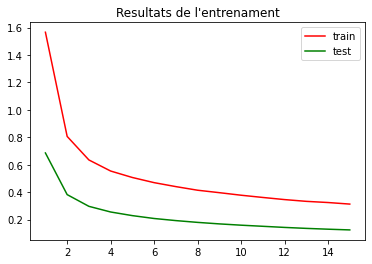

In [12]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();

## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa. 

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el groun truth com a títol de la imatge.
3. Visualitzar el resultat de la mateixa imatge passada per tots els filtres de cada convolució de la vostra xarxa.
4. **Extra**: Fer la matriu de confusió de les 10 classes per poder entendre el que no estau fent bé (la xarxa no està fent bé).

A tenir en compte:

#### Subplots

Per fer graelles d'imatges podeu empar la funció `subplots`. Més [informació](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

#### Device

Si heu emprat _GPU_ per accelerar el procés d'entrenament, els resultats que obtenim de la xarxa també seràn a la _GPU_. **Pytorch** proporciona la funció `cpu()` que retorna una còpia d'aquest objecte a la memòria de la CPU.

#### Detach
Per poder operar amb els resultats de la predicció emprarem la funció `detach` que retorna un nou Tensor "separat" del graf (xarxa) en curs.

Per tant per transformar el tensor que retorna la xarxa en un array de la lliberia _Numpy_ caldria fer el següent:

  ```
  resultat_np = resultat.detach().numpy()
  ```
Si a més hem executat l'entrenament en _GPU_:
  ```
  resultat_np = resultat.cpu().detach().numpy()
  ```


#### 1. Predicció del conjunt de test

In [13]:
from sklearn.metrics import accuracy_score

model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output,_ , _ = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.9627


#### 2 Visualització de la primera imatge del batch i veure la seva predicció

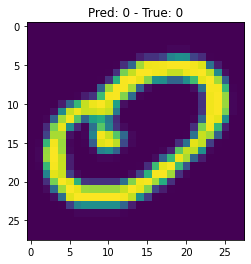

In [14]:
def generador(loader):
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        yield data, target

gen = generador(test_loader)

data, true_labels = next(gen)

model.eval()

output, f1, f2 = model(data)

labels = output.detach().cpu().numpy()
images = data.cpu().numpy()
labels = np.argmax(labels, axis=1)

plt.title(f'Pred: {classes[labels[0]]} - True: {classes[int(true_labels[0])]}')
plt.imshow(images[0,0,:,:]);

 Sortida de la primera capa convolucional

#### 3 Visualitzar el resultat de la mateixa imatge passada per tots els filtres de cada convolució de la xarxa.

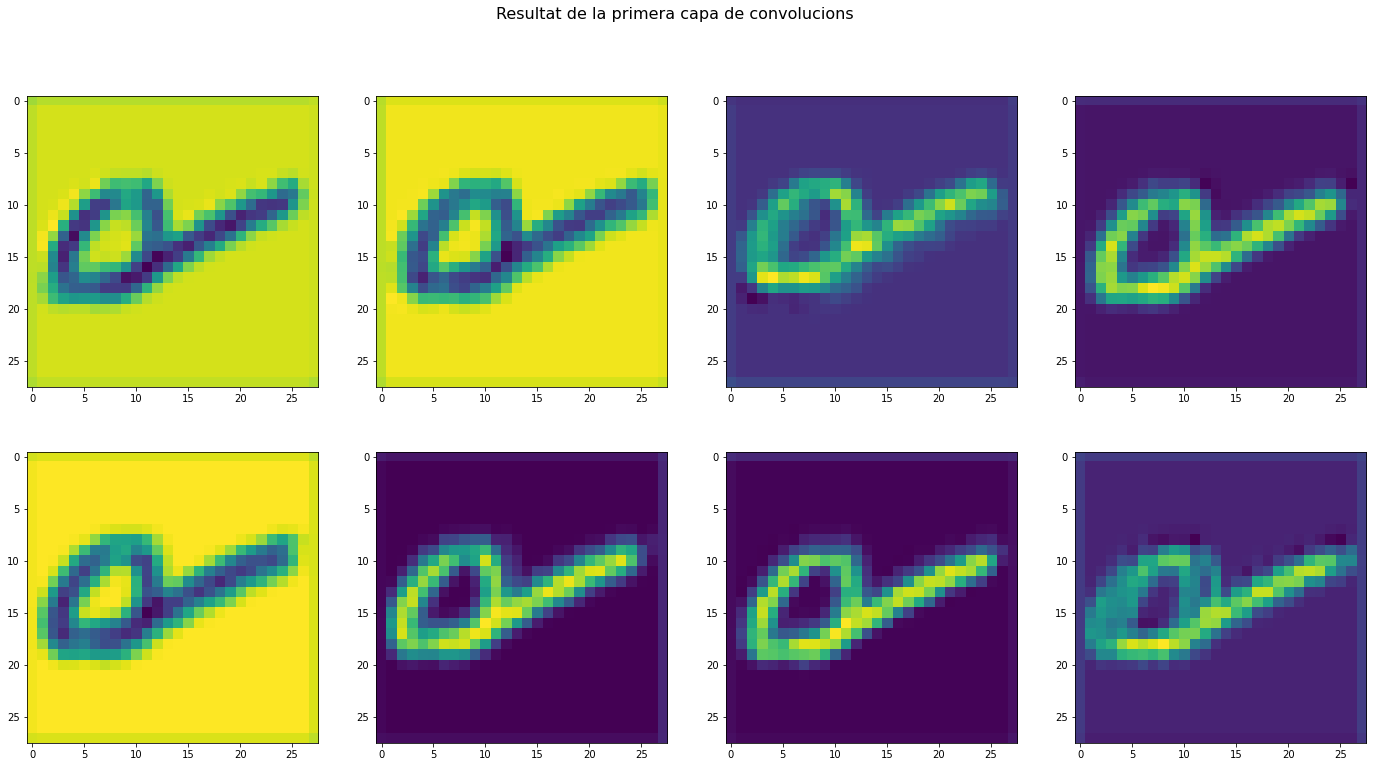

In [15]:
rows= 2
cols = 4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 12))
fig.suptitle('Resultat de la primera capa de convolucions', fontsize=16)

for i in range(rows):
    for j in range(cols):        
        if img_count < rows*cols:
            axes[i, j].imshow(f1.detach().cpu().numpy()[1,img_count,:,:])
            
            img_count+=1
            
fig.set
plt.show()

#### 4 Fer la matriu de confusió de les 10 classes per poder entendre el que no estau fent bé (la xarxa no està fent bé).

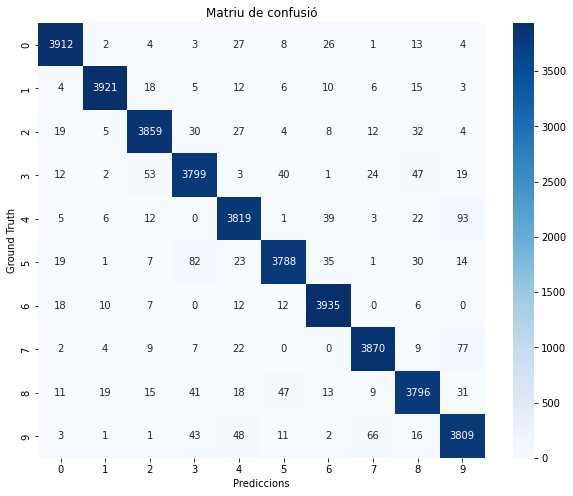

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets, predictions)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Prediccions')
plt.ylabel('Ground Truth')
plt.title('Matriu de confusió')
plt.show()

### Nombre de paràmetres de la xarxa

In [16]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

26698